<a href="https://colab.research.google.com/github/86lekwenshiung/West-Nile-Virus-Prediction/blob/main/Project_4_West_Nile_Virus_Terence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction : West Nile Virus
___

**Problem Statement**

1. Given weather, location, testing, and spraying data, predict when and where different species of mosquitos will test positive for West Nile virus. 
2. Is pesticide effective : Population before 2011 vs Population After 2013.


**Key variables**

|Data|Description|
|---|---|
|Id|Id of the Mosquito|
|Species|Species of Mosquito|
|Address|Location of Trap|
|Block| Block nunber of address|
|Street| Street Name|
|Trap ID| Id of Trap. Letter behind Trap ID indicate it is near a main Trap|
|Latitude , Longtitude|Location of Trap , Mosquito|
|NumMosquito| No. of Mosquito|
|WNV_Present| 1 means WNV is present, and 0 means not present|
|Spray CSV| Latitude , Longtitude. Dataset only at 2011, 2013|

**Model Explored**

**workflow**
1. EDA
2. Feature Engineering 
3. Data Preprocessing
4. Modelling to predict WNV probability (without pesticide)
5. Select best Model to study the effect of pesticide
  * 5.1 Hypothesis : Pesticide has no effect on Mosquito population

**Key Insight**

We need to derive an effective plan to deploy pesticides throughout the city, and that is exactly where you come in!  


# 0.0 Libraries Import
___

In [1]:
# General Utilities
import datetime
from datetime import date

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries

# 1.0 Data Import
___

In [2]:
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/train.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/weather.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/test.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/spray.csv

--2021-10-21 08:47:49--  https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1797335 (1.7M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]   1.71M  --.-KB/s    in 0.01s   

2021-10-21 08:47:50 (135 MB/s) - ‘train.csv’ saved [1797335/1797335]

--2021-10-21 08:47:50--  https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/weather.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 20

### 1.1 Data Exploration
___

In [3]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
df_spray = pd.read_csv('/content/spray.csv')
df_weather = pd.read_csv('/content/weather.csv')

In [4]:
df_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [5]:
print(f'Shape of DF: {df_train.shape}')
print('---------------------------')
print(f'Count of Null in Dataframe: {df_train.isnull().sum().sum()}')
print(f'Percentage of Null: {df_train.isnull().sum().sum()/len(df_train)}%')
print('---------------------------')
print(f'Count of Duplicate in Dataframe: {df_train.duplicated().sum()}')

Shape of DF: (10506, 12)
---------------------------
Count of Null in Dataframe: 0
Percentage of Null: 0.0%
---------------------------
Count of Duplicate in Dataframe: 813


# 2.0 General EDA
___

In [6]:
print('Earliest Date in DF:' , df_train['Date'].min())
print('Latest Date in DF:' , df_train['Date'].max())

Earliest Date in DF: 2007-05-29
Latest Date in DF: 2013-09-26


### 2.1 EDA on Traps and Mosquito Population
___
* There are 136 Unique Traps

In [7]:
print('No. of Unique Traps:' , df_train['Trap'].nunique())
print('Total Mosquito in Dataset:' , df_train['NumMosquitos'].sum())
print('-----------------------------------------')
print('No. Max Mosquito In Trap :' , df_train['NumMosquitos'].max())

No. of Unique Traps: 136
Total Mosquito in Dataset: 135039
-----------------------------------------
No. Max Mosquito In Trap : 50


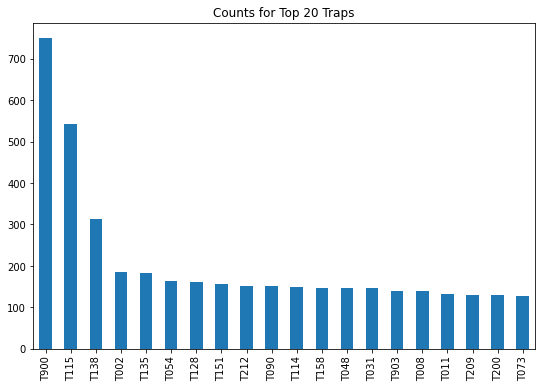

In [8]:
# Visualising top 20 traps with most count

df_train['Trap'].value_counts()[:20].plot(kind = 'bar' , figsize = (9,6))
plt.title('Counts for Top 20 Traps');

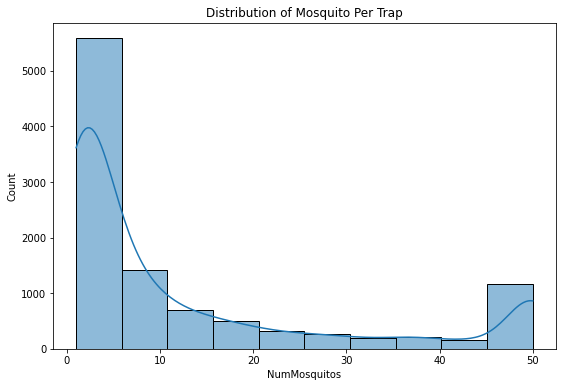

In [9]:
# Distribution of Mosquito Per Traps

plt.figure(figsize = (9,6))
sns.histplot(df_train['NumMosquitos'] , bins = 10 , kde = True);
plt.title('Distribution of Mosquito Per Trap');

### 2.2 EDA on Mosquito Species
___

In [10]:
print('No. of Unique Species:' , df_train['Species'].nunique())

No. of Unique Species: 7


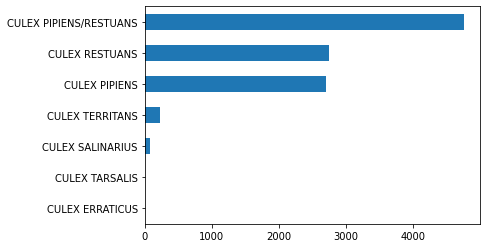

In [11]:
df_train['Species'].value_counts().sort_values(ascending = True).plot(kind = 'barh');

### 2.3 EDA on Species and presence of WNV
___

* Less than 1% of the Carrier Mosquito for 3 of the high population had WNV Virus detected.

In [12]:
df_wnv_percent = df_train.groupby(by = 'Species').agg({'WnvPresent' : np.sum , 'NumMosquitos' : np.sum})
df_wnv_percent['Percentage'] = df_wnv_percent['WnvPresent'] / df_wnv_percent['NumMosquitos'] * 100
df_wnv_percent

,WnvPresent,NumMosquitos,Percentage
Species,,,
CULEX ERRATICUS,0,7,0.000000
CULEX PIPIENS,240,44671,0.537261
CULEX PIPIENS/RESTUANS,262,66268,0.395364
CULEX RESTUANS,49,23431,0.209125
CULEX SALINARIUS,0,145,0.000000
CULEX TARSALIS,0,7,0.000000
CULEX TERRITANS,0,510,0.000000


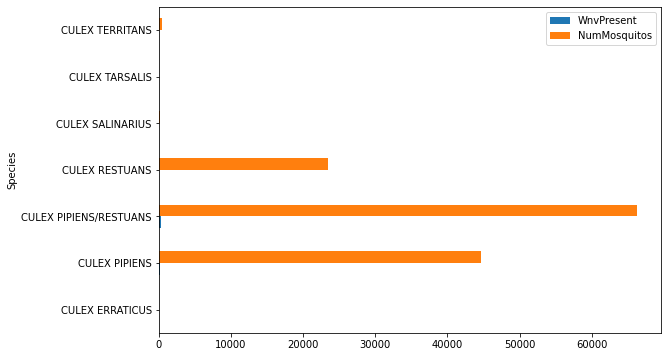

In [13]:
df_wnv_percent[['WnvPresent' , 'NumMosquitos']].plot(kind = 'barh' , figsize = (9,6));

### 2.4 EDA on Location
___

* There are 136 Unique Traps but 138 unique location.

In [64]:
df_train[['Latitude' , 'Longitude']].nunique()

Latitude     138
Longitude    138
dtype: int64

In [67]:
df_train[['Latitude' , 'Longitude']].duplicated()

0        False
1         True
2        False
3        False
4         True
         ...  
10501     True
10502     True
10503     True
10504     True
10505     True
Length: 10506, dtype: bool

#3.0 Creating Extra Features
___

In [14]:
df_train['Year'] = pd.to_datetime(df_train['Date']).dt.year
df_train['Month'] = pd.to_datetime(df_train['Date']).dt.month
df_train['Weekofyear'] = pd.to_datetime(df_train['Date']).dt.isocalendar().week

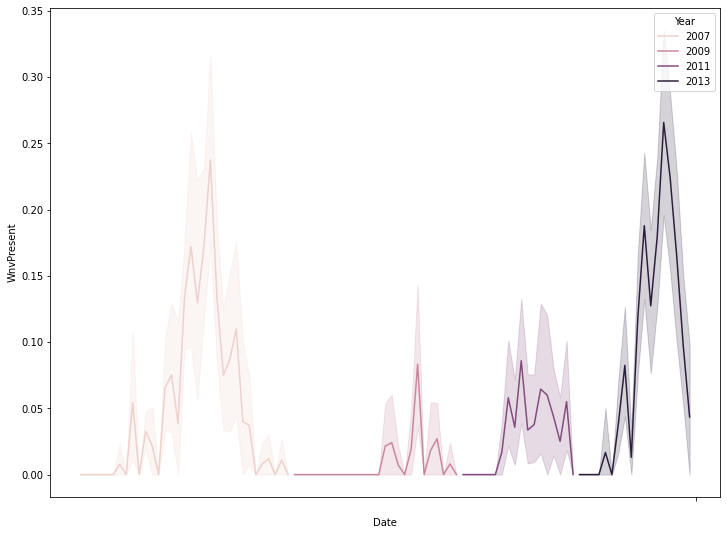

In [15]:
plt.figure(figsize = (12,9))
sns.lineplot(data = df_train,
             hue = 'Year',
             x = 'Date',
             y = 'WnvPresent')
plt.xticks(' ');

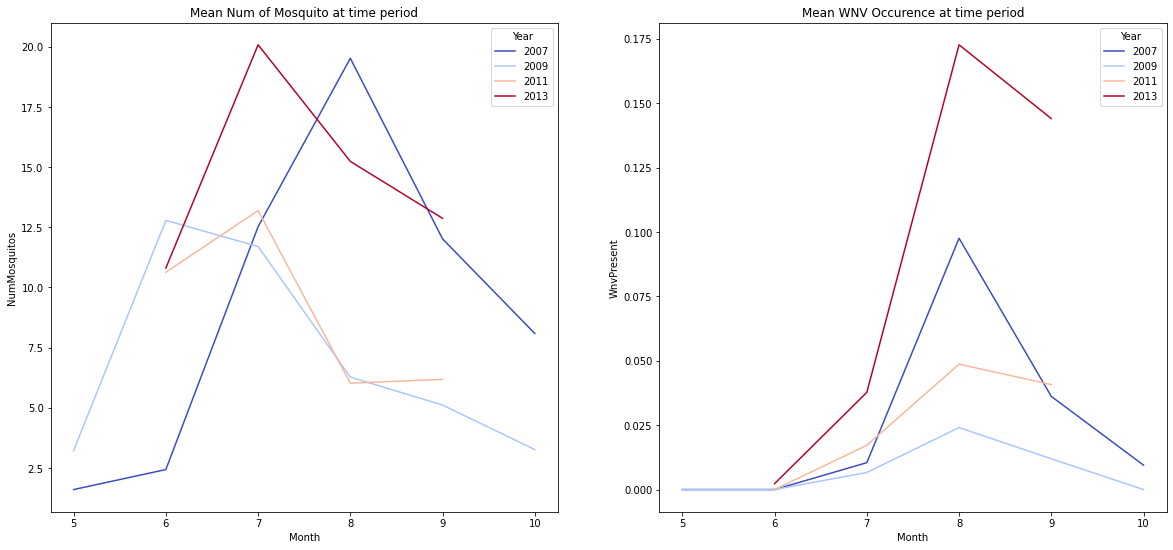

In [58]:
plt.figure(figsize = (20,9))

plt.subplot(1,2,1)
df_timeline = df_train[['Year' , 'Month' , 'WnvPresent' , 'NumMosquitos']]
sns.lineplot(data = df_timeline,
             x  = 'Month',
             y = 'NumMosquitos',
             hue = 'Year',
             ci = None,
             palette = 'coolwarm')
plt.title('Mean Num of Mosquito at time period')

plt.subplot(1,2,2)
df_timeline = df_train[['Year' , 'Month' , 'WnvPresent' , 'NumMosquitos']]
sns.lineplot(data = df_timeline,
             x  = 'Month',
             y = 'WnvPresent',
             hue = 'Year',
             ci = None,
             palette = 'coolwarm')
plt.title('Mean WNV Occurence at time period');

In [59]:
# Random Cross check on value from Plots
df_timeline[(df_timeline['Year'] == 2007) & (df_timeline['Month'] == 8)].mean()

Year            2007.000000
Month              8.000000
WnvPresent         0.097561
NumMosquitos      19.519512
dtype: float64